# 5: The Many Variables & The Spurious Waffles

Man, I love the chapter titles.

In [1]:
%cd ~/statistical-rethinking

/home/ecotner/statistical-rethinking


In [2]:
%load_ext autoreload
%autoreload 2

In [36]:
import sys
import warnings

import pandas as pd
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import networkx as nx

import torch
import torch.tensor as tt
import torch.nn as nn
import pyro
from pyro.infer import Predictive, SVI, Trace_ELBO
from pyro.infer.autoguide import (
    AutoLaplaceApproximation,
    AutoDiagonalNormal,
    AutoMultivariateNormal,
    init_to_value
)
from pyro.optim import Adam
from pyro.distributions import Normal, Uniform, Beta, Exponential, LogNormal

sys.path.insert(0, "/home/ecotner/statistical-rethinking/code")
from utils import HPDI

### Code 5.1
Load up the `WaffleDivorce` dataset and standardize the variables

In [4]:
waffle_df = pd.read_csv("data/WaffleDivorce.csv", sep=";")
waffle_df.sample(3)

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
13,Illinois,IL,12.83,27.0,17.9,0.58,8.0,0.45,2,0,0,1711951,0.0
8,District of Columbia,DC,0.60,29.7,17.7,2.53,6.3,1.89,0,0,0,75080,0.0
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.0


In [5]:
waffle_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Population,50.0,6.119600,6.876156,0.56,1.6350,4.435,6.6775,37.25
MedianAgeMarriage,50.0,26.054000,1.243630,23.20,25.3250,25.900,26.7500,29.70
Marriage,50.0,20.114000,3.797905,13.50,17.1250,19.700,22.1000,30.70
Marriage SE,50.0,1.399400,0.796975,0.39,0.8100,1.185,1.7675,3.92
Divorce,50.0,9.688000,1.820814,6.10,8.3000,9.750,10.9000,13.50
Divorce SE,50.0,0.961800,0.525367,0.24,0.5725,0.795,1.2575,2.50
WaffleHouses,50.0,32.340000,65.789587,0.00,0.0000,1.000,39.7500,381.00
South,50.0,0.280000,0.453557,0.00,0.0000,0.000,1.0000,1.00
Slaves1860,50.0,79378.340000,149730.921149,0.00,0.0000,0.000,80828.0000,490865.00
Population1860,50.0,628729.280000,781312.662599,0.00,43321.0000,407722.000,920977.0000,3880735.00


In [6]:
# Standardize variables
class WaffleDataset:
    def __init__(self, df):
        self.params = dict()
        for k1, k2 in (("MedianAgeMarriage", "A"), ("Divorce", "D"), ("Marriage", "M")):
            self.params[f"{k2}_mean"] = df[k1].mean()
            self.params[f"{k2}_std"] = df[k1].values.std()
            s = self.standardize(df[k1].values, k2)
            setattr(self, k2, df[k1].values) # raw values
            setattr(self, f"{k2}s", s) # standardized values
            
    def standardize(self, x, name):
        return (x - self.params[f"{name}_mean"])/self.params[f"{name}_std"]
    
    def unstandardize(self, x, name):
        return self.params[f"{name}_mean"] + self.params[f"{name}_std"] * x
    
wdata = WaffleDataset(waffle_df)

### Code 5.2
Standard deviation of age at marriage?

In [7]:
wdata.params["A_std"]

1.231131187160816

### Code 5.3
Do linear regression on $A$ and $D$

In [8]:
class RegressionModel:
    def __init__(self, x, y, prefix:str=""):
        self.x = tt(x).double()
        self.y = tt(y).double()
        self.name = prefix
        
    def __call__(self, x=None):
        nm = self.name + "/" if self.name != "" else ""
        a = pyro.sample(f"{nm}alpha", Normal(*tt((0., 0.2))))
        bA = pyro.sample(f"{nm}beta", Normal(*tt((0., 0.5))))
        sigma = pyro.sample(f"{nm}sigma", Exponential(tt(1.)))
        if x is None:
            mu = pyro.deterministic(f"{nm}mu", a + bA * self.x)
            pyro.sample(f"{nm}D", Normal(mu, sigma), obs=self.y)
        else:
            mu = pyro.deterministic(f"{nm}mu", a + bA * x)
            return pyro.sample(f"{nm}D", Normal(mu, sigma))
        
    def train(self, num_steps):
        pyro.clear_param_store()
        self.guide = AutoMultivariateNormal(self)
        svi = SVI(
            model=self,
            guide=self.guide,
            optim=Adam({"lr": 1e-3}),
            loss=Trace_ELBO(),
        )
        loss = list()
        for _ in tqdm.notebook.tnrange(num_steps):
            loss.append(svi.step())
        return loss

In [9]:
m5_1 = RegressionModel(wdata.As, wdata.Ds, prefix="m1")
loss = m5_1.train(1500)

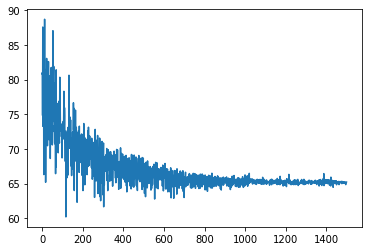

In [10]:
plt.plot(loss); plt.show()

### Code 5.4
Simulate from the prior

In [11]:
x = wdata.As
x = torch.linspace(x.min(), x.max(), 100)
samples = {
    k: v.detach().numpy()
    for k, v in Predictive(
        m5_1, {},
        num_samples=100,
        return_sites=("m1/alpha", "m1/beta")
    )(x).items()
}

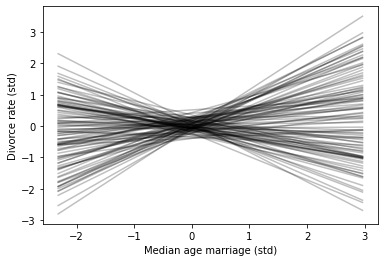

In [12]:
for a, b, in zip(samples["m1/alpha"], samples["m1/beta"]):
    y = a + b*x
    plt.plot(x, y, color="black", alpha=0.25)
plt.xlabel("Median age marriage (std)")
plt.ylabel("Divorce rate (std)")
plt.show()

### Code 5.5
Sample from posterior and draw the HPDI of the regression line

In [13]:
# Draw samples
x = wdata.As
x = torch.linspace(x.min(), x.max(), 100)
samples1 = {
    k: v.detach().numpy()
    for k, v in Predictive(
        m5_1,
        guide=m5_1.guide,
        num_samples=10000,
    )(x).items()
}

In [14]:
# Calculate HPDI
hpdi = dict()
for k in ["m1/mu", "m1/D"]:
    hpdi[k] = np.vstack([HPDI(samples1[k][:,i], 0.89) for i in range(100)])

[]

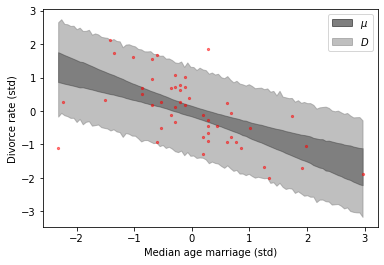

In [15]:
# plot
plt.fill_between(x, *hpdi["m1/mu"].T, color="black", alpha=0.5, label="$\mu$")
plt.fill_between(x, *hpdi["m1/D"].T, color="gray", alpha=0.5, label="$D$")
plt.scatter(wdata.As, wdata.Ds, color="red", alpha=0.5, s=5)
plt.xlabel("Median age marriage (std)")
plt.ylabel("Divorce rate (std)")
plt.legend()
plt.plot()

### Code 5.6
Do the same thing but for the marriage rate/divorce rate

In [16]:
m5_2 = RegressionModel(wdata.Ms, wdata.Ds, prefix="m2")
loss = m5_2.train(1500)

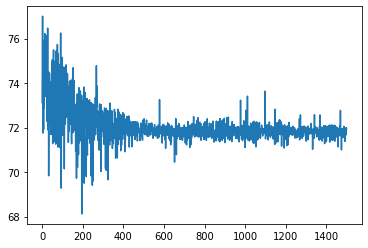

In [17]:
plt.plot(loss); plt.show()

In [18]:
# Draw samples
x = wdata.Ms
x = torch.linspace(x.min(), x.max(), 100)
samples2 = {
    k: v.detach().numpy()
    for k, v in Predictive(
        m5_2,
        guide=m5_2.guide,
        num_samples=10000,
    )(x).items()
}

In [19]:
# Calculate HPDI
hpdi = dict()
for k in ("m2/mu", "m2/D"):
    hpdi[k] = np.vstack([HPDI(samples2[k][:,i], 0.89) for i in range(100)])

[]

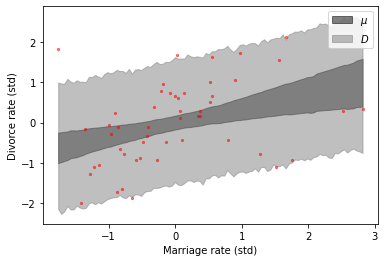

In [20]:
# plot
plt.fill_between(x, *hpdi["m2/mu"].T, color="black", alpha=0.5, label="$\mu$")
plt.fill_between(x, *hpdi["m2/D"].T, color="gray", alpha=0.5, label="$D$")
plt.scatter(wdata.Ms, wdata.Ds, color="red", alpha=0.5, s=5)
plt.xlabel("Marriage rate (std)")
plt.ylabel("Divorce rate (std)")
plt.legend()
plt.plot()

### Code 5.7
Create the first DAG and draw it

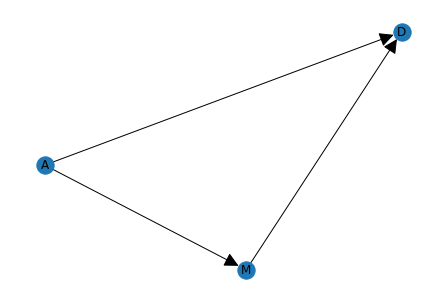

In [21]:
G1 = nx.DiGraph()
G1.add_nodes_from("ADM")
G1.add_edges_from([("A","D"), ("A","M"), ("M","D")])
nx.draw(G1, with_labels=True, arrowsize=30)

### Code 5.8/5.9
Make the second DAG and find the conditional independencies of both DAGs

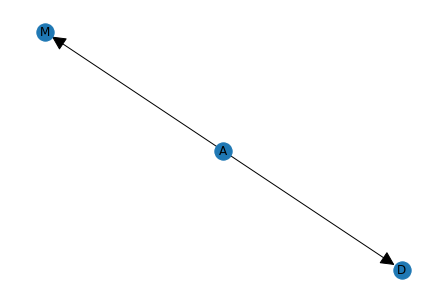

In [22]:
G2 = nx.DiGraph()
G2.add_nodes_from("ADM")
G2.add_edges_from([("A","D"), ("A","M")])
nx.draw(G2, with_labels=True, arrowsize=30)

I don't think `networkx` has a way of computing conditional independencies, but it is clear that the first DAG has none, since any node is connected to any other node, and the first DAG only has $M \perp\!\!\perp D | A$ due to the fact that the only way to get from M to D is through A.

Note that these are not the only DAGs we can draw using these variables. There are many more that should be considered, and looking at just these two likely isn't enough to determine the full causal diagram. In general, there could be feedback loops of some kind because we aren't taking time evolution into account.

### Code 5.10
Perform multiple linear regression on the divorce rate using both age at marriage and marriage rate as predictors

In [23]:
class MultipleRegression:
    def __init__(self, X, y, prefix=""):
        self.X = X
        self.y = y
        self.n_vars = int(X.shape[-1])
        self.name = prefix
        
    def __call__(self, X=None):
        nm = self.name + "/" if self.name != "" else ""
        alpha = pyro.sample(f"{nm}alpha", Normal(*tt((0., 0.2)).double()))
        sigma = pyro.sample(f"{nm}sigma", Exponential(tt(1.).double()))
        beta = pyro.sample(f"{nm}beta", Normal(*tt((0., 0.5)).double()).expand([self.n_vars]))
        if X is None:
            mu = pyro.deterministic(f"{nm}mu", alpha + torch.matmul(self.X, beta))
            pyro.sample(f"{nm}D", Normal(mu, sigma), obs=self.y)
        else:
            mu = pyro.deterministic(f"{nm}mu", alpha + torch.matmul(X, beta))
            return pyro.sample(f"{nm}D", Normal(mu, sigma))
        
    def train(self, n_steps):
#         self.guide = AutoLaplaceApproximation(self)
        self.guide = AutoMultivariateNormal(self)
        pyro.clear_param_store()
        svi = SVI(self, self.guide, optim=Adam({"lr": 1e-3}), loss=Trace_ELBO())
        loss = list()
        for _ in tqdm.notebook.tnrange(n_steps):
            step_loss = svi.step()
            loss.append(step_loss)
#         self.guide = self.guide.laplace_approximation(self.X)
        return loss

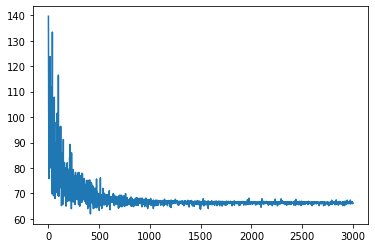

In [24]:
X = tt([wdata.As, wdata.Ms]).T.double()
y = tt(wdata.Ds).double()
m5_3 = MultipleRegression(X, y, prefix="m3")
loss = m5_3.train(3000)
plt.plot(loss); plt.show()

### Code 5.11
Plot the coefficients' HPDI for the various models

In [25]:
samples3 = {
    k: v.detach().numpy()
    for k, v in Predictive(
        m5_3,
        guide=m5_3.guide,
        num_samples=10000,
    )().items()
}

In [26]:
summary = {
    1: {
        "beta_A": {
            "hpdi": HPDI(samples1["m1/beta"], 0.89),
            "mean": samples1["m1/beta"].mean(),
        },
        "beta_M": None,
    },
    2: {
        "beta_M": {
            "hpdi": HPDI(samples2["m2/beta"], 0.89),
            "mean": samples2["m2/beta"].mean(),
        },
        "beta_A": None,
    },
    3: {
        "beta_A": {
            "hpdi": HPDI(samples3["m3/beta"][:,0], 0.89),
            "mean": samples3["m3/beta"][:,0].mean(),
        },
        "beta_M": {
            "hpdi": HPDI(samples3["m3/beta"][:,1], 0.89),
            "mean": samples3["m3/beta"][:,1].mean(),
        },
    },
}

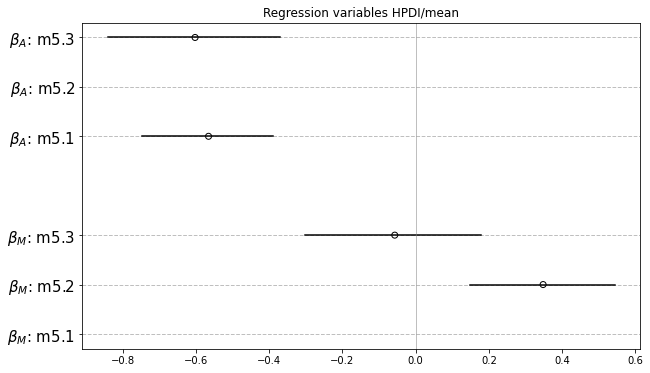

In [27]:
plt.figure(figsize=(10, 6))
ticks = list()
for i, model in summary.items():
    for var, vals in model.items():
        if var == "beta_A":
            y = i + 4
        else:
            y = i
        plt.axhline(y, color="gray", linestyle="--", linewidth=1, alpha=0.5)
        ticks.append((y, fr"$\{var}$"f": m5.{i}"))
        if vals is None: continue
        for k, v in vals.items():
            if k == "mean":
                plt.scatter(v, y, facecolor="none", edgecolor="black")
            elif k == "hpdi":
                plt.plot(v, [y, y], color="black")
plt.axvline(0, color="gray", linewidth=1, alpha=0.5)
plt.yticks(*zip(*ticks), fontsize=15)
plt.title("Regression variables HPDI/mean")
plt.show()

### Code 5.12
The inferred DAG implies a simple simulation to reproduce the dataset:

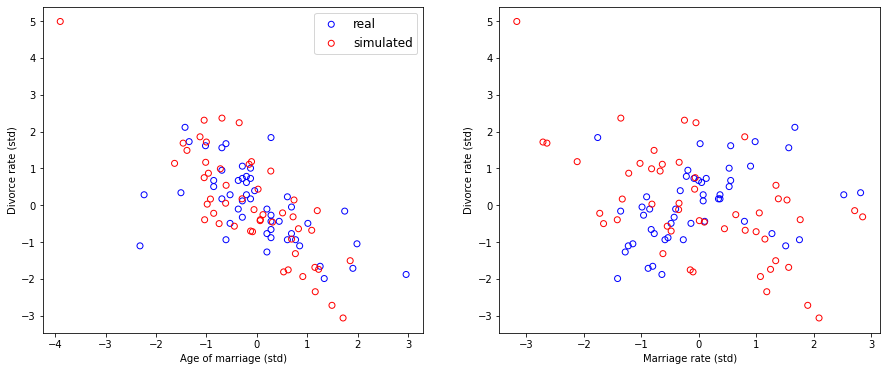

In [28]:
N = 50
age = np.random.randn(N)
mar = np.random.randn(N) + age
div = np.random.randn(N) - age

fig, axes = plt.subplots(ncols=2, figsize=(15, 6))
plt.sca(axes[0])
plt.scatter(wdata.As, wdata.Ds, edgecolor="blue", facecolor="none", label="real")
plt.scatter(age, div, edgecolor="red", facecolor="none", label="simulated")
plt.xlabel("Age of marriage (std)")
plt.ylabel("Divorce rate (std)")
plt.legend(fontsize=12)
plt.sca(axes[1])
plt.scatter(wdata.Ms, wdata.Ds, edgecolor="blue", facecolor="none")
plt.scatter(mar, div, edgecolor="red", facecolor="none")
plt.xlabel("Marriage rate (std)")
plt.ylabel("Divorce rate (std)")
plt.show()

### Code 5.13-5.14
Regress the marriage rate as a linear function of the age at marriage and vice versa, so that we can use it to build a _predictor residual plot_

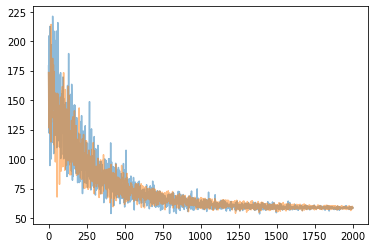

In [58]:
a = tt(wdata.As).double()
m = tt(wdata.Ms).double()
m5_4_m = RegressionModel(wdata.As, wdata.Ms, prefix="M_res")
loss = m5_4_m.train(2000)
plt.plot(loss, alpha=0.5)
samples_m = {
    k: v.detach().numpy()
    for k, v in Predictive(
        m5_4_m,
        guide=m5_4_m.guide,
        num_samples=1000,
        return_sites=("M_res/mu",)
    )(a).items()
}
m5_4_a = RegressionModel(wdata.Ms, wdata.As, prefix="A_res")
loss = m5_4_a.train(2000)
plt.plot(loss, alpha=0.5); plt.show()
samples_a = {
    k: v.detach().numpy()
    for k, v in Predictive(
        m5_4_a,
        guide=m5_4_a.guide,
        num_samples=1000,
        return_sites=("A_res/mu",)
    )(m).items()
}

The _residuals_ are computed by subtracting the observed marriage rate from the predicted rate (the mean $\mu$), based on the model above

In [72]:
from scipy.stats import linregress

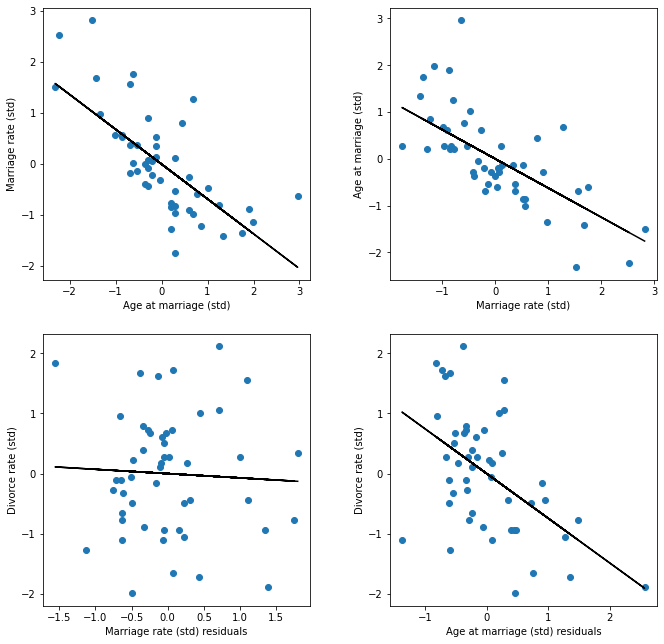

In [77]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(11, 11))
# Plot of age vs marriage rate
plt.sca(axes[0,0])
plt.scatter(a, m)
mu_m = samples_m["M_res/mu"].mean(axis=0)
plt.plot(a, mu_m, color="black")
plt.xlabel("Age at marriage (std)")
plt.ylabel("Marriage rate (std)")
# Plot of marriage vs age
plt.sca(axes[0,1])
plt.scatter(m, a)
mu_a = samples_a["A_res/mu"].mean(axis=0)
plt.plot(m, mu_a, color="black")
plt.xlabel("Marriage rate (std)")
plt.ylabel("Age at marriage (std)")
# Marriage residuals vs divorce
plt.sca(axes[1,0])
res = m - mu_m
plt.scatter(res, wdata.Ds)
m_, b, _, _, _ = linregress(res, wdata.Ds)
plt.plot(res, m_*res + b, color="black")
plt.xlabel("Marriage rate (std) residuals")
plt.ylabel("Divorce rate (std)")
# Age residuals vs divorce
plt.sca(axes[1,1])
res = a - samples_a["A_res/mu"].mean(axis=0)
plt.scatter(res, wdata.Ds)
m_, b, _, _, _ = linregress(res, wdata.Ds)
plt.plot(res, m_*res + b, color="black")
plt.xlabel("Age at marriage (std) residuals")
plt.ylabel("Divorce rate (std)")

plt.subplots_adjust(wspace=0.3)
plt.show()

### Code 5.15-5.16
Sample from the posterior of the multivariate regression and compare (mean) predictions vs. the actuals

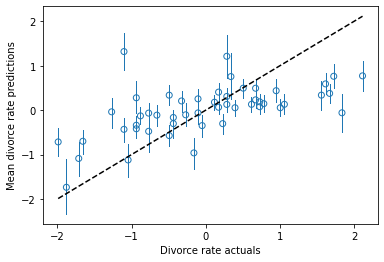

In [100]:
mu = samples3["m3/mu"].mean(axis=0)
mu_hpdi = np.array([HPDI(x, 0.89) for x in samples3["m3/mu"].T])
plt.scatter(wdata.Ds, mu, facecolor="none", edgecolor="C0")
for q, d in zip(mu_hpdi, wdata.Ds):
    plt.plot((d, d), q, color="C0", linewidth=1)
x = np.linspace(wdata.Ds.min(), wdata.Ds.max())
plt.plot(x, x, color="black", linestyle="--")
plt.xlabel("Divorce rate actuals")
plt.ylabel("Mean divorce rate predictions")
plt.show()